<a href="https://colab.research.google.com/github/b1becker/love_to_hate_sentiment_analysis/blob/main/aaron_rodgers_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install praw pandas numpy requests matplotlib seaborn textblob vaderSentiment transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 11.5 MB/s eta 0:00:00


In [4]:
from google.colab import userdata
CLIENT_ID = userdata.get('REDDIT_CLIENT_ID')
CLIENT_SECRET = userdata.get('REDDIT_CLIENT_SECRET')

In [13]:
import praw
import pandas as pd
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

class RedditAaronRodgersSentimentAnalyzer:
    def __init__(self):
        """Initialize the Reddit-only sentiment analyzer for Aaron Rodgers"""
        self.reddit = None
        self.vader_analyzer = SentimentIntensityAnalyzer()
        self.posts_data = []

    def setup_reddit_api(self, client_id: str, client_secret: str, user_agent: str):
        """
        Setup Reddit API - FREE with registration

        Steps to get FREE Reddit API access:
        1. Go to https://www.reddit.com/prefs/apps
        2. Click "Create App" or "Create Another App"
        3. Fill out the form:
           - Name: AaronRodgersSentiment
           - App type: Select "script"
           - Description: Sentiment analysis of Aaron Rodgers posts
           - About URL: (leave blank)
           - Redirect URI: http://localhost:8080
        4. Click "Create app"
        5. Copy the client_id (random string under app name) and client_secret

        Rate Limits: 60 requests per minute, 600 per hour - completely FREE
        """
        try:
            self.reddit = praw.Reddit(
                client_id=client_id,
                client_secret=client_secret,
                user_agent=user_agent
            )
            # Test the connection
            print(f"✅ Reddit API connected successfully!")
            try:
                user = self.reddit.user.me()
                print(f"✅ Authenticated as: {user}")
            except:
                print("✅ Connected in read-only mode (perfect for scraping)")
            return True
        except Exception as e:
            print(f"❌ Reddit API setup failed: {e}")
            print("💡 Double-check your client_id and client_secret")
            return False

    def scrape_aaron_rodgers_posts(self, limit: int = 1000, days_back: int = 365):
        """
        Scrape real Aaron Rodgers posts from Reddit

        Args:
            limit: Maximum number of posts to scrape
            days_back: How many days back to search
        """
        if not self.reddit:
            print("❌ Reddit API not configured. Call setup_reddit_api() first.")
            return []

        print(f"🔍 Scraping {limit} Aaron Rodgers posts from the last {days_back} days...")

        # Subreddits to search (NFL-focused)
        subreddits = [
            'nfl',              # Main NFL subreddit
            'GreenBayPackers',  # His longtime team
            'NYJets',           # Current team
            'fantasyfootball',  # Fantasy discussions
            'DynastyFF',        # Dynasty fantasy
            'CHIBears',         # NFC North rival
            'detroitlions',     # NFC North rival
            'minnesotavikings', # NFC North rival
            'NFLNoobs',         # General NFL discussion
            'sports',           # General sports
            'football'          # General football
        ]

        # Search terms for Aaron Rodgers content
        search_terms = [
            'Aaron Rodgers',
            'A-Rod',
            'Rodgers',
            'Aaron',
            '#AaronRodgers'
        ]

        posts_data = []
        posts_per_sub = max(1, limit // len(subreddits))

        for subreddit_name in subreddits:
            try:
                subreddit = self.reddit.subreddit(subreddit_name)
                print(f"📡 Searching r/{subreddit_name}...")

                # Try multiple search approaches
                posts_found = 0

                # 1. Search for each term
                for term in search_terms:
                    try:
                        for submission in subreddit.search(
                            term,
                            sort='new',
                            time_filter='year',
                            limit=posts_per_sub // len(search_terms)
                        ):
                            # Check if post is within our date range
                            post_date = datetime.fromtimestamp(submission.created_utc)
                            if post_date < datetime.now() - timedelta(days=days_back):
                                continue

                            # Skip if we already have this post
                            if any(p['id'] == submission.id for p in posts_data):
                                continue

                            # Get post data
                            post_data = self.extract_post_data(submission, subreddit_name)
                            if post_data:
                                posts_data.append(post_data)
                                posts_found += 1

                            # Rate limiting - be nice to Reddit
                            time.sleep(0.1)

                            if len(posts_data) >= limit:
                                break

                        if len(posts_data) >= limit:
                            break

                    except Exception as e:
                        print(f"⚠️ Search error for '{term}' in r/{subreddit_name}: {e}")
                        continue

                print(f"  📊 Found {posts_found} posts in r/{subreddit_name}")

            except Exception as e:
                print(f"⚠️ Error accessing r/{subreddit_name}: {e}")
                continue

            if len(posts_data) >= limit:
                print(f"✅ Reached target of {limit} posts!")
                break

        print(f"✅ Total scraped: {len(posts_data)} posts successfully!")
        self.posts_data = posts_data
        return posts_data

    def extract_post_data(self, submission, subreddit_name: str) -> Dict:
        """Extract comprehensive data from a Reddit submission"""
        try:
            post_data = {
                'id': submission.id,
                'title': submission.title,
                'selftext': submission.selftext or '',
                'score': submission.score,
                'upvote_ratio': submission.upvote_ratio,
                'num_comments': submission.num_comments,
                'created_utc': datetime.fromtimestamp(submission.created_utc),
                'subreddit': subreddit_name,
                'url': submission.url,
                'author': str(submission.author) if submission.author else '[deleted]',
                'is_self': submission.is_self,
                'permalink': f"https://reddit.com{submission.permalink}",
                'gilded': submission.gilded,
                'distinguished': submission.distinguished,
                'stickied': submission.stickied
            }

            # Get top comments for additional context
            try:
                submission.comments.replace_more(limit=0)
                top_comments = []
                comment_count = 0

                for comment in submission.comments:
                    if comment_count >= 10:  # Limit to top 10 comments
                        break

                    if hasattr(comment, 'body') and comment.body not in ['[deleted]', '[removed]']:
                        comment_data = {
                            'body': comment.body,
                            'score': comment.score,
                            'created_utc': datetime.fromtimestamp(comment.created_utc),
                            'author': str(comment.author) if comment.author else '[deleted]'
                        }
                        top_comments.append(comment_data)
                        comment_count += 1

                post_data['top_comments'] = top_comments
                post_data['comments_analyzed'] = len(top_comments)

            except Exception as e:
                print(f"⚠️ Error getting comments for post {submission.id}: {e}")
                post_data['top_comments'] = []
                post_data['comments_analyzed'] = 0

            return post_data

        except Exception as e:
            print(f"⚠️ Error extracting post data: {e}")
            return None

    def analyze_sentiment_comprehensive(self, text: str) -> Dict:
        """
        Comprehensive sentiment analysis using multiple methods
        Uses only offline methods - no external API calls needed
        """
        # Clean the text
        text = text.replace('\n', ' ').replace('\r', ' ')
        text = ' '.join(text.split())  # Remove extra whitespace

        results = {}

        # 1. TextBlob Analysis
        try:
            blob = TextBlob(text)
            results['textblob_polarity'] = blob.sentiment.polarity  # -1 to 1
            results['textblob_subjectivity'] = blob.sentiment.subjectivity  # 0 to 1
        except Exception as e:
            print(f"TextBlob error: {e}")
            results['textblob_polarity'] = 0
            results['textblob_subjectivity'] = 0.5

        # 2. VADER Analysis
        try:
            vader_scores = self.vader_analyzer.polarity_scores(text)
            results['vader_compound'] = vader_scores['compound']  # -1 to 1
            results['vader_positive'] = vader_scores['pos']
            results['vader_negative'] = vader_scores['neg']
            results['vader_neutral'] = vader_scores['neu']
        except Exception as e:
            print(f"VADER error: {e}")
            results.update({
                'vader_compound': 0,
                'vader_positive': 0,
                'vader_negative': 0,
                'vader_neutral': 1
            })

        # 3. Calculate composite negativity score
        negativity_components = []

        # From TextBlob (convert polarity to negativity)
        if results['textblob_polarity'] < 0:
            negativity_components.append(abs(results['textblob_polarity']))

        # From VADER
        negativity_components.append(results['vader_negative'])

        # Average negativity
        results['negativity_score'] = np.mean(negativity_components) if negativity_components else 0

        return results

    def process_all_posts_sentiment(self):
        """Process sentiment analysis for all scraped posts"""
        if not self.posts_data:
            print("❌ No posts data available. Run scrape_aaron_rodgers_posts() first.")
            return []

        print(f"🧠 Analyzing sentiment for {len(self.posts_data)} posts...")

        processed_posts = []

        for i, post in enumerate(self.posts_data):
            # Combine all text for analysis
            full_text = f"{post['title']} {post['selftext']}"

            # Add top comments to analysis
            if post['top_comments']:
                comments_text = " ".join([comment['body'] for comment in post['top_comments']])
                full_text += f" {comments_text}"

            # Analyze sentiment
            sentiment_results = self.analyze_sentiment_comprehensive(full_text)

            # Combine with post metadata
            post_analysis = {
                **post,  # All original post data
                **sentiment_results,  # All sentiment scores
                'full_text_length': len(full_text),
                'analysis_date': datetime.now()
            }

            # Calculate hate index (composite metric)
            reddit_negativity = max(0, -post['score']) / 100 if post['score'] < 0 else 0
            controversy_factor = post['num_comments'] / 100
            low_upvote_ratio = max(0, 0.5 - post['upvote_ratio']) * 2  # Penalty for low upvote ratio

            post_analysis['hate_index'] = (
                post_analysis['negativity_score'] * 3 +  # Weight sentiment heavily
                reddit_negativity +  # Negative scores indicate dislike
                controversy_factor * 0.3 +  # High comment count can indicate controversy
                low_upvote_ratio * 0.5  # Low upvote ratio indicates controversy
            )

            processed_posts.append(post_analysis)

            # Progress indicator
            if (i + 1) % 25 == 0:
                print(f"📊 Processed {i + 1}/{len(self.posts_data)} posts...")

        print("✅ Sentiment analysis complete!")
        return processed_posts

    def create_comprehensive_dashboard(self, sentiment_data: List[Dict]):
        """Create a comprehensive dashboard with multiple visualizations"""
        df = pd.DataFrame(sentiment_data)

        # Create the main figure
        fig = plt.figure(figsize=(20, 14))
        gs = fig.add_gridspec(5, 4, height_ratios=[0.4, 1, 1, 1, 1])

        # Main title
        fig.suptitle('🏈 AARON RODGERS REDDIT SENTIMENT ANALYSIS DASHBOARD 🏈',
                    fontsize=24, fontweight='bold', color='darkgreen', y=0.97)

        # Calculate key metrics
        avg_negativity = df['negativity_score'].mean()
        max_negativity = df['negativity_score'].max()
        total_posts = len(df)
        avg_reddit_score = df['score'].mean()
        total_comments = df['num_comments'].sum()
        date_range = f"{df['created_utc'].min().strftime('%Y-%m-%d')} to {df['created_utc'].max().strftime('%Y-%m-%d')}"

        # Top metrics row
        ax_metrics = fig.add_subplot(gs[0, :])
        metrics_text = f"""
        📊 POSTS: {total_posts:,} | 📅 PERIOD: {date_range} | 🔴 AVG NEGATIVITY: {avg_negativity:.3f} |
        ⚡ PEAK NEGATIVITY: {max_negativity:.3f} | 📈 AVG SCORE: {avg_reddit_score:.1f} | 🗣️ COMMENTS: {total_comments:,}
        """
        ax_metrics.text(0.5, 0.5, metrics_text, ha='center', va='center',
                       fontsize=14, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))
        ax_metrics.axis('off')

        # 1. Sentiment over time
        ax_timeline = fig.add_subplot(gs[1, :2])
        df_sorted = df.sort_values('created_utc')
        ax_timeline.scatter(df_sorted['created_utc'], df_sorted['negativity_score'],
                           c=df_sorted['score'], cmap='RdYlGn', alpha=0.6, s=30)
        ax_timeline.plot(df_sorted['created_utc'], df_sorted['negativity_score'].rolling(10).mean(),
                        color='red', linewidth=2, label='10-post moving average')
        ax_timeline.set_title('Negativity Timeline', fontsize=14, fontweight='bold')
        ax_timeline.set_ylabel('Negativity Score')
        ax_timeline.legend()
        ax_timeline.grid(True, alpha=0.3)

        # 2. Subreddit comparison
        ax_subreddit = fig.add_subplot(gs[1, 2:])
        subreddit_stats = df.groupby('subreddit').agg({
            'negativity_score': 'mean',
            'score': 'mean',
            'id': 'count'
        }).round(3)
        subreddit_stats = subreddit_stats.sort_values('negativity_score', ascending=False)

        bars = ax_subreddit.barh(range(len(subreddit_stats)), subreddit_stats['negativity_score'],
                                color='red', alpha=0.7)
        ax_subreddit.set_yticks(range(len(subreddit_stats)))
        ax_subreddit.set_yticklabels([f"r/{sub} ({subreddit_stats.loc[sub, 'id']} posts)"
                                     for sub in subreddit_stats.index])
        ax_subreddit.set_title('Average Negativity by Subreddit', fontsize=14, fontweight='bold')
        ax_subreddit.set_xlabel('Negativity Score')

        # 3. Most hated posts table (adaptive based on available columns)
        # Use hate_percentage if available, otherwise use hate_index
        if 'hate_percentage' in df.columns:
            most_hated = df.nlargest(15, 'hate_percentage')
            hate_col_name = 'Hate %'
            table_title = '🔥 TOP 15 MOST HATED POSTS (by Hate %) 🔥'
        else:
            most_hated = df.nlargest(15, 'hate_index')
            hate_col_name = 'Hate Idx'
            table_title = '🔥 TOP 15 MOST HATED POSTS (by Hate Index) 🔥'

        ax_table = fig.add_subplot(gs[2:4, :2])
        ax_table.axis('off')
        ax_table.set_title(table_title, fontsize=16, fontweight='bold', color='red', pad=20)

        # Create table data
        table_data = []
        for i, (_, row) in enumerate(most_hated.iterrows(), 1):
            title_short = row['title'][:50] + "..." if len(row['title']) > 50 else row['title']

            if 'hate_percentage' in df.columns:
                hate_value = f"{row['hate_percentage']:.1f}%"
                emoji = row.get('hate_emoji', '😡')
                table_data.append([
                    f"{i}",
                    title_short,
                    hate_value,
                    emoji,
                    f"{row['score']:.0f}",
                    f"r/{row['subreddit']}",
                    row['created_utc'].strftime('%m/%d')
                ])
                col_labels = ['#', 'Post Title', hate_col_name, '😡', 'Score', 'Sub', 'Date']
                col_widths = [0.04, 0.5, 0.08, 0.05, 0.08, 0.15, 0.1]
            else:
                hate_value = f"{row['hate_index']:.2f}"
                table_data.append([
                    f"{i}",
                    title_short,
                    hate_value,
                    f"{row['score']:.0f}",
                    f"r/{row['subreddit']}",
                    row['created_utc'].strftime('%m/%d')
                ])
                col_labels = ['#', 'Post Title', hate_col_name, 'Score', 'Sub', 'Date']
                col_widths = [0.05, 0.55, 0.1, 0.1, 0.15, 0.05]

        table = ax_table.table(cellText=table_data,
                              colLabels=col_labels,
                              cellLoc='left',
                              loc='center',
                              colWidths=col_widths)

        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 1.2)

        # Color code table rows
        for i in range(len(table_data)):
            if 'hate_percentage' in df.columns:
                hate_value = float(table_data[i][2].replace('%', ''))
                # Color based on hate percentage
                if hate_value >= 81:
                    color = '#8B0000'  # Dark red
                    text_color = 'white'
                elif hate_value >= 61:
                    color = '#FF4444'  # Red
                    text_color = 'white'
                elif hate_value >= 41:
                    color = '#FF8888'  # Light red
                    text_color = 'black'
                elif hate_value >= 21:
                    color = '#FFCCCC'  # Very light red
                    text_color = 'black'
                else:
                    color = '#FFFFFF'  # White
                    text_color = 'black'
            else:
                hate_value = float(table_data[i][2])
                # Color based on hate index
                if hate_value >= 3.0:
                    color = '#8B0000'  # Dark red
                    text_color = 'white'
                elif hate_value >= 2.0:
                    color = '#FF4444'  # Red
                    text_color = 'white'
                elif hate_value >= 1.0:
                    color = '#FF8888'  # Light red
                    text_color = 'black'
                else:
                    color = '#FFCCCC'  # Very light red
                    text_color = 'black'

            for j in range(len(col_labels)):
                table[(i+1, j)].set_facecolor(color)
                table[(i+1, j)].set_text_props(color=text_color)

        # 4. Sentiment distribution
        ax_dist = fig.add_subplot(gs[2, 2:])
        ax_dist.hist(df['negativity_score'], bins=25, alpha=0.7, color='red', edgecolor='black')
        ax_dist.axvline(avg_negativity, color='blue', linestyle='--', linewidth=2,
                       label=f'Average: {avg_negativity:.3f}')
        ax_dist.set_title('Negativity Score Distribution', fontsize=14, fontweight='bold')
        ax_dist.set_xlabel('Negativity Score')
        ax_dist.set_ylabel('Number of Posts')
        ax_dist.legend()
        ax_dist.grid(True, alpha=0.3)

        # 5. Controversy analysis
        ax_controversy = fig.add_subplot(gs[3, 2:])
        scatter = ax_controversy.scatter(df['score'], df['num_comments'],
                                        c=df['negativity_score'], cmap='Reds',
                                        s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
        ax_controversy.set_title('Controversy Analysis\n(Reddit Score vs Comments)', fontsize=14, fontweight='bold')
        ax_controversy.set_xlabel('Reddit Score')
        ax_controversy.set_ylabel('Number of Comments')
        ax_controversy.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax_controversy, label='Negativity Score')

        # 6. VADER Analysis Summary
        ax_methods = fig.add_subplot(gs[4, :])

        # VADER category breakdown
        vader_categories = {
            'Extremely Negative\n(≤ -0.6)': len(df[df['vader_compound'] <= -0.6]),
            'Negative\n(-0.6 to -0.2)': len(df[(df['vader_compound'] > -0.6) & (df['vader_compound'] <= -0.2)]),
            'Slightly Negative\n(-0.2 to -0.05)': len(df[(df['vader_compound'] > -0.2) & (df['vader_compound'] <= -0.05)]),
            'Neutral\n(-0.05 to 0.05)': len(df[(df['vader_compound'] > -0.05) & (df['vader_compound'] <= 0.05)]),
            'Positive\n(> 0.05)': len(df[df['vader_compound'] > 0.05])
        }

        categories = list(vader_categories.keys())
        counts = list(vader_categories.values())
        colors = ['darkred', 'red', 'orange', 'gray', 'lightgreen']

        bars = ax_methods.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black')

        # Add percentage labels on bars
        total_posts = len(df)
        for bar, count in zip(bars, counts):
            percentage = (count / total_posts) * 100
            height = bar.get_height()
            ax_methods.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{count}\n({percentage:.1f}%)', ha='center', va='bottom',
                           fontweight='bold', fontsize=10)

        ax_methods.set_title('VADER Sentiment Category Breakdown', fontsize=16, fontweight='bold')
        ax_methods.set_ylabel('Number of Posts')
        ax_methods.grid(True, alpha=0.3, axis='y')

        # Add summary text
        negative_total = vader_categories['Extremely Negative\n(≤ -0.6)'] + vader_categories['Negative\n(-0.6 to -0.2)']
        negative_percentage = (negative_total / total_posts) * 100

        summary_text = f"🔥 {negative_percentage:.1f}% of posts are clearly negative about Aaron Rodgers"
        ax_methods.text(0.5, 0.95, summary_text, transform=ax_methods.transAxes,
                       ha='center', va='top', fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.8))

        plt.tight_layout()
        plt.subplots_adjust(top=0.94)
        return fig

    def generate_detailed_report(self, sentiment_data: List[Dict]) -> str:
        """Generate a comprehensive text report"""
        df = pd.DataFrame(sentiment_data)

        report = "🏈 AARON RODGERS REDDIT SENTIMENT ANALYSIS REPORT 🏈\n"
        report += "=" * 70 + "\n\n"

        # Summary statistics
        report += "📊 SUMMARY STATISTICS:\n"
        report += f"Total posts analyzed: {len(df):,}\n"
        report += f"Date range: {df['created_utc'].min().strftime('%Y-%m-%d')} to {df['created_utc'].max().strftime('%Y-%m-%d')}\n"
        report += f"Average negativity score: {df['negativity_score'].mean():.3f}\n"
        report += f"Maximum negativity score: {df['negativity_score'].max():.3f}\n"
        report += f"Average Reddit score: {df['score'].mean():.1f}\n"
        report += f"Total comments analyzed: {df['num_comments'].sum():,}\n"
        report += f"Subreddits covered: {df['subreddit'].nunique()}\n\n"

        # Subreddit breakdown
        report += "📈 SUBREDDIT BREAKDOWN:\n"
        subreddit_summary = df.groupby('subreddit').agg({
            'negativity_score': ['mean', 'max', 'count'],
            'score': 'mean'
        }).round(3)

        for subreddit in subreddit_summary.index:
            neg_mean = subreddit_summary.loc[subreddit, ('negativity_score', 'mean')]
            neg_max = subreddit_summary.loc[subreddit, ('negativity_score', 'max')]
            count = subreddit_summary.loc[subreddit, ('negativity_score', 'count')]
            score_mean = subreddit_summary.loc[subreddit, ('score', 'mean')]

            report += f"r/{subreddit}: {count} posts, avg negativity: {neg_mean:.3f}, avg score: {score_mean:.1f}\n"

        report += "\n"

        # Top 25 most hated posts
        report += "🔥 TOP 25 MOST HATED POSTS:\n"
        report += "-" * 50 + "\n"

        most_hated = df.nlargest(25, 'hate_index')
        for i, (_, row) in enumerate(most_hated.iterrows(), 1):
            report += f"\n#{i} - HATE INDEX: {row['hate_index']:.3f}\n"
            report += f"Title: {row['title']}\n"
            report += f"Subreddit: r/{row['subreddit']}\n"
            report += f"Reddit Score: {row['score']:.0f} | Comments: {row['num_comments']}\n"
            report += f"Upvote Ratio: {row['upvote_ratio']:.2f}\n"
            report += f"Date: {row['created_utc'].strftime('%Y-%m-%d %H:%M')}\n"
            report += f"Negativity Score: {row['negativity_score']:.3f}\n"
            report += f"Link: {row['permalink']}\n"

            # Add snippet of text
            full_text = f"{row['title']} {row['selftext']}"
            if len(full_text) > 150:
                full_text = full_text[:150] + "..."
            report += f"Preview: {full_text}\n"
            report += "-" * 40 + "\n"

        return report

    def save_comprehensive_results(self, sentiment_data: List[Dict], filename_base: str = 'aaron_rodgers_reddit_sentiment'):
        """Save all results to multiple files"""
        df = pd.DataFrame(sentiment_data)

        # Save detailed CSV with all data
        csv_filename = f'{filename_base}_detailed.csv'
        df.to_csv(csv_filename, index=False)
        print(f"✅ Detailed data saved to: {csv_filename}")

        # Save summary CSV with key metrics only
        summary_df = df[['title', 'subreddit', 'score', 'num_comments', 'created_utc',
                        'negativity_score', 'hate_index', 'permalink']].copy()
        summary_filename = f'{filename_base}_summary.csv'
        summary_df.to_csv(summary_filename, index=False)
        print(f"✅ Summary data saved to: {summary_filename}")

        # Save comprehensive text report
        report = self.generate_detailed_report(sentiment_data)
        report_filename = f'{filename_base}_report.txt'
        with open(report_filename, 'w', encoding='utf-8') as f:
            f.write(report)
        print(f"✅ Detailed report saved to: {report_filename}")

        # Save top hated posts as separate file for easy sharing
        most_hated = df.nlargest(50, 'hate_index')[['title', 'subreddit', 'hate_index', 'score', 'permalink']]
        hated_filename = f'{filename_base}_top_hated.csv'
        most_hated.to_csv(hated_filename, index=False)
        print(f"✅ Top hated posts saved to: {hated_filename}")

def run_aaron_rodgers_analysis():
    """Main function to run the complete Aaron Rodgers sentiment analysis"""
    print("🚀 AARON RODGERS REDDIT SENTIMENT ANALYZER")
    print("=" * 50)
    print("This tool analyzes real Reddit posts about Aaron Rodgers")
    print("using only the Reddit API and offline sentiment analysis.\n")

    # Initialize analyzer
    analyzer = RedditAaronRodgersSentimentAnalyzer()

    # Get Reddit credentials from secrets or user input
    client_id = None
    client_secret = None

    # Try to get from different secret systems
    try:
        # Google Colab
        from google.colab import userdata
        client_id = userdata.get('REDDIT_CLIENT_ID')
        client_secret = userdata.get('REDDIT_CLIENT_SECRET')
        print("✅ Using credentials from Google Colab secrets")
    except:
        try:
            # Kaggle
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            client_id = user_secrets.get_secret("REDDIT_CLIENT_ID")
            client_secret = user_secrets.get_secret("REDDIT_CLIENT_SECRET")
            print("✅ Using credentials from Kaggle secrets")
        except:
            try:
                # Environment variables (local/cloud)
                import os
                client_id = os.environ.get('REDDIT_CLIENT_ID')
                client_secret = os.environ.get('REDDIT_CLIENT_SECRET')
                if client_id and client_secret:
                    print("✅ Using credentials from environment variables")
            except:
                pass

    # If no secrets found, ask user for input
    if not client_id or not client_secret:
        print("📱 REDDIT API SETUP:")
        print("Get your FREE credentials at: https://www.reddit.com/prefs/apps")
        print("Create a 'script' type app and get your client_id and client_secret\n")

        client_id = input("Enter your Reddit client_id: ").strip()
        if not client_id:
            print("❌ Client ID is required. Please get it from Reddit API.")
            return

        client_secret = input("Enter your Reddit client_secret: ").strip()
        if not client_secret:
            print("❌ Client secret is required. Please get it from Reddit API.")
            return

    user_agent = "AaronRodgersSentiment/1.0"

    # Setup Reddit API
    if not analyzer.setup_reddit_api(client_id, client_secret, user_agent):
        print("❌ Failed to setup Reddit API. Please check your credentials.")
        return

    # Get user preferences
    print("\n⚙️ ANALYSIS SETTINGS:")
    try:
        num_posts = int(input("How many posts to analyze? (default 500): ") or "500")
        days_back = int(input("How many days back to search? (default 365): ") or "365")
    except ValueError:
        num_posts = 500
        days_back = 365
        print("Using default settings: 500 posts, 365 days")

    # Start analysis
    print(f"\n🔍 Starting analysis of {num_posts} posts from last {days_back} days...")

    # Step 1: Scrape posts
    posts = analyzer.scrape_aaron_rodgers_posts(limit=num_posts, days_back=days_back)
    if not posts:
        print("❌ No posts found. Try adjusting your search parameters.")
        return

    # Step 2: Analyze sentiment
    print("🧠 Analyzing sentiment...")
    sentiment_data = analyzer.process_all_posts_sentiment()

    # Step 3: Create dashboard
    print("📊 Creating dashboard...")
    dashboard = analyzer.create_comprehensive_dashboard(sentiment_data)
    dashboard_filename = 'aaron_rodgers_reddit_dashboard.png'
    dashboard.savefig(dashboard_filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Dashboard saved as: {dashboard_filename}")

    # Step 4: Save all results
    print("💾 Saving results...")
    analyzer.save_comprehensive_results(sentiment_data)

    # Final summary
    df = pd.DataFrame(sentiment_data)
    print(f"\n🎉 ANALYSIS COMPLETE!")
    print("=" * 30)
    print(f"📊 Analyzed {len(df)} posts")
    print(f"🔴 Average negativity: {df['negativity_score'].mean():.3f}")
    print(f"⚡ Peak negativity: {df['negativity_score'].max():.3f}")
    print(f"🏆 Most hated post: '{df.loc[df['hate_index'].idxmax(), 'title'][:60]}...'")
    print(f"📅 Date range: {df['created_utc'].min().date()} to {df['created_utc'].max().date()}")

    # Show the dashboard
    plt.show()

if __name__ == "__main__":
    print("🏈 Aaron Rodgers Reddit Sentiment Analysis Tool")
    print("=" * 50)
    print("📋 Required Google Colab Secrets:")
    print("   • REDDIT_CLIENT_ID")
    print("   • REDDIT_CLIENT_SECRET")
    print("\n📦 Required packages:")
    print("!pip install praw pandas numpy textblob vaderSentiment matplotlib seaborn")
    print("\n🚀 To run the analysis:")
    print("run_aaron_rodgers_analysis()")

    # Uncomment the line below to run automatically:
    # run_aaron_rodgers_analysis()

🏈 Aaron Rodgers Reddit Sentiment Analysis Tool
📋 Required Google Colab Secrets:
   • REDDIT_CLIENT_ID
   • REDDIT_CLIENT_SECRET

📦 Required packages:
!pip install praw pandas numpy textblob vaderSentiment matplotlib seaborn

🚀 To run the analysis:
run_aaron_rodgers_analysis()


🚀 AARON RODGERS REDDIT SENTIMENT ANALYZER
This tool analyzes real Reddit posts about Aaron Rodgers
using only the Reddit API and offline sentiment analysis.

✅ Using credentials from Google Colab secrets
✅ Reddit API connected successfully!
✅ Authenticated as: None

⚙️ ANALYSIS SETTINGS:
How many posts to analyze? (default 500): 1000
How many days back to search? (default 365): 1285


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




🔍 Starting analysis of 1000 posts from last 1285 days...
🔍 Scraping 1000 Aaron Rodgers posts from the last 1285 days...
📡 Searching r/nfl...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 44 posts in r/nfl
📡 Searching r/GreenBayPackers...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 40 posts in r/GreenBayPackers
📡 Searching r/NYJets...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 43 posts in r/NYJets
📡 Searching r/fantasyfootball...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 53 posts in r/fantasyfootball
📡 Searching r/DynastyFF...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 39 posts in r/DynastyFF
📡 Searching r/CHIBears...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 37 posts in r/CHIBears
📡 Searching r/detroitlions...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 44 posts in r/detroitlions
📡 Searching r/minnesotavikings...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 36 posts in r/minnesotavikings
📡 Searching r/NFLNoobs...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 33 posts in r/NFLNoobs
📡 Searching r/sports...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 20 posts in r/sports
📡 Searching r/football...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  📊 Found 6 posts in r/football
✅ Total scraped: 395 posts successfully!
🧠 Analyzing sentiment...
🧠 Analyzing sentiment for 395 posts...
📊 Processed 25/395 posts...
📊 Processed 50/395 posts...
📊 Processed 75/395 posts...
📊 Processed 100/395 posts...
📊 Processed 125/395 posts...
📊 Processed 150/395 posts...
📊 Processed 175/395 posts...
📊 Processed 200/395 posts...
📊 Processed 225/395 posts...
📊 Processed 250/395 posts...
📊 Processed 275/395 posts...
📊 Processed 300/395 posts...
📊 Processed 325/395 posts...
📊 Processed 350/395 posts...
📊 Processed 375/395 posts...
✅ Sentiment analysis complete!
📊 Creating dashboard...
✅ Dashboard saved as: aaron_rodgers_reddit_dashboard.png
💾 Saving results...
✅ Detailed data saved to: aaron_rodgers_reddit_sentiment_detailed.csv
✅ Summary data saved to: aaron_rodgers_reddit_sentiment_summary.csv
✅ Detailed report saved to: aaron_rodgers_reddit_sentiment_report.txt
✅ Top hated posts saved to: aaron_rodgers_reddit_sentiment_top_hated.csv

🎉 ANALYSIS COMPLE

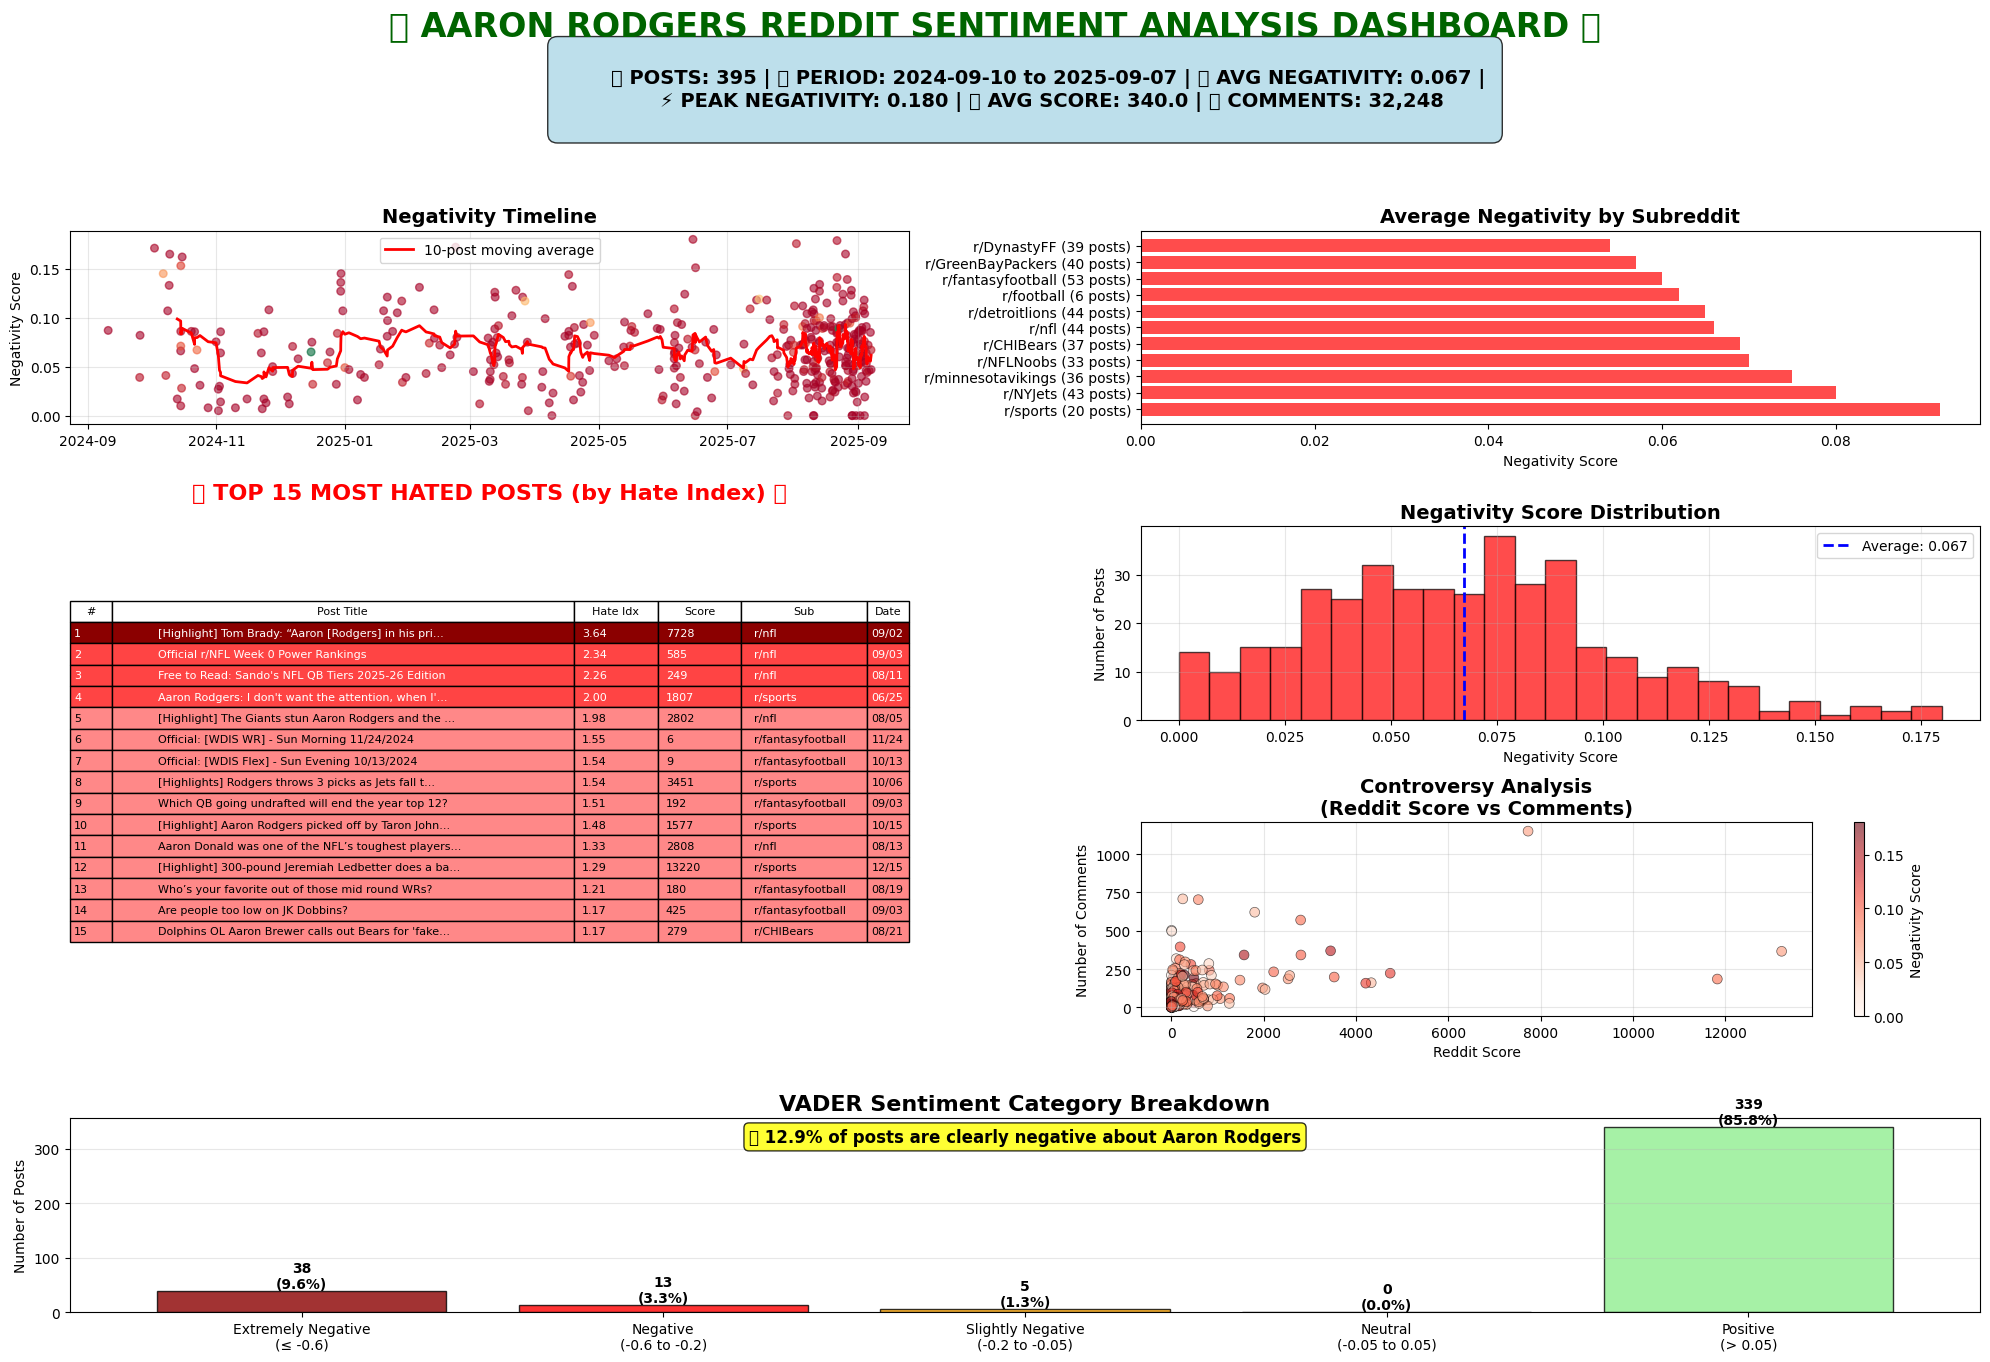

In [14]:
run_aaron_rodgers_analysis()